In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# 1️ Load dataset
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df['category'] = df['category'].astype(int)

X = df['clean_comment']
y = df['category']

# 2️ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️ TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


C:\jupyter\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.8980
Precision: 0.8983
Recall: 0.8980
F1-score: 0.8980


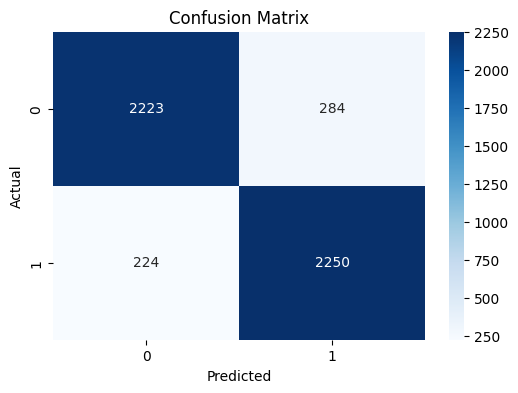

In [3]:
# 4️ Base Learners
base_learners = [
    ('xgb', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, n_estimators=200, max_depth=6, learning_rate=0.1)),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=-1, learning_rate=0.1)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ('nb', MultinomialNB(alpha=0.5)),
    ('lr', LogisticRegression(max_iter=1000))
]

# 5️ Stacking Classifier
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

# 6️ Train model
stack_model.fit(X_train_tfidf, y_train)

# 7️ Predictions
y_pred = stack_model.predict(X_test_tfidf)

# 8️ Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# 9️ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [4]:
# Save model
with open('stacking_model.pkl', 'wb') as f:
    pickle.dump((stack_model, vectorizer), f)

print(" Model saved as stacking_model.pkl")

 Model saved as stacking_model.pkl
